# Cargo 2000 dataset
## Context
## Regression Tree
## Dataset preparation

In [36]:
# Import necessary libraries
from encodings import search_function
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

from scipy import stats
from scipy.stats import norm, skew #for some statistics

# Import necessary tools from the sklearn library
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Import sklearn library tools used ONLY for validating my results
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, f1_score, accuracy_score, recall_score, precision_score, auc, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.decomposition import PCA
from scipy.stats import randint as sp_randint
import warnings
warnings.filterwarnings('ignore')

In [37]:
# load datasets function
def load_data(data_file_name):
    data_dir = "..\..\..\data\data_regression"
    data_path = os.path.join(data_dir, data_file_name)
    df = pd.read_csv(data_path)
    data_X = df.iloc[:,:-1]
    data_y = df.iloc[:,-1]
    scaler_X = StandardScaler()
    data_X = scaler_X.fit_transform(data_X)
    scaler_y = MinMaxScaler()
    data_y = np.array(data_y)
    data_y = scaler_y.fit_transform(data_y.reshape(-1,1)).reshape(-1)
    return data_X, data_y

In [38]:
def main():
    
    # read dataset from csv file
    data_name = "c2k_regression"
    data_X, data_y = load_data("{}.csv".format(data_name))
    data_X, data_y = pd.DataFrame(data_X), pd.Series(data_y)
    data_y = (data_y - data_y.mean()) / data_y.std()

    # Randomly assingning a train and test set
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.33, random_state=2200)
    return train_X, test_X, train_y, test_y, data_X, data_y

In [42]:
# I am loading the full dataset and renaming the columns to keep better track of each attribute
data_dir = "..\..\..\data\data_regression"
data_path = os.path.join(data_dir, "c2k_regression.csv")
df = pd.read_csv(data_path, header=0)
df.columns

Index(['nr', 'i1_legid', 'i1_rcs_p', 'i1_rcs_e', 'i1_dep_1_p', 'i1_dep_1_e',
       'i1_dep_1_place', 'i1_rcf_1_p', 'i1_rcf_1_e', 'i1_rcf_1_place',
       'i1_dep_2_p', 'i1_dep_2_e', 'i1_dep_2_place', 'i1_rcf_2_p',
       'i1_rcf_2_e', 'i1_rcf_2_place', 'i1_dep_3_p', 'i1_dep_3_e',
       'i1_dep_3_place', 'i1_rcf_3_p', 'i1_rcf_3_e', 'i1_rcf_3_place',
       'i1_dlv_p', 'i1_dlv_e', 'i1_hops', 'i2_legid', 'i2_rcs_p', 'i2_rcs_e',
       'i2_dep_1_p', 'i2_dep_1_e', 'i2_dep_1_place', 'i2_rcf_1_p',
       'i2_rcf_1_e', 'i2_rcf_1_place', 'i2_dep_2_p', 'i2_dep_2_e',
       'i2_dep_2_place', 'i2_rcf_2_p', 'i2_rcf_2_e', 'i2_rcf_2_place',
       'i2_dep_3_p', 'i2_dep_3_e', 'i2_dep_3_place', 'i2_rcf_3_p',
       'i2_rcf_3_e', 'i2_rcf_3_place', 'i2_dlv_p', 'i2_dlv_e', 'i2_hops',
       'i3_legid', 'i3_rcs_p', 'i3_rcs_e', 'i3_dep_1_p', 'i3_dep_1_e',
       'i3_dep_1_place', 'i3_rcf_1_p', 'i3_rcf_1_e', 'i3_rcf_1_place',
       'i3_dep_2_p', 'i3_dep_2_e', 'i3_dep_2_place', 'i3_rcf_2_p',
       'i3_rcf

# 1.2 Implement the class of regression tree

In [39]:
### criterion function for regression tree
def sum_squared_distance_to_mean(X, y):
    '''
    function used to calculate the squared error.
    '''
    n = X.shape[0]
    return np.var(y) * n

class DecisionTreeRegressor(object):
    '''
    This class is for decision tree regression

    Attributes:
        - criterion: a function used as the criterion of decision tree regression
        - tolS: a tolerance on the error reduction. we will stop the splitting if
            low error reduction.
        - tree: a nested dictionary representing the decision tree structure.
    '''
    def __init__(self, criterion, tolS=0.1):
        # Initialization
        self.criterion = criterion
        self.tolS = tolS

    def fit(self, X, y):
        '''
        function used to fit the decision tree regressor

        Args:
            X - features of training samples, a pandas dataframe with shape (n, d), where
                X.columns is the column name of X, and we can use X['feat'] to index all
                values of the feature named `feat`.
            y - target values (continuous, scaled) of training samples, a pandas series with shape (n,)
        '''
        self.tree = self.create_tree(X, y)

    def predict(self, X):
        '''
        function used to fit the decision tree regressor

        Args:
            X - features of test samples, a pandas dataframe with shape (n, d)

        Returns:
            y - predictions of test samples, a pandas series with shape (n,)
        '''
        n = X.shape[0]
        y = []
        for i in range(n):
            y.append(self.predict_each(X.iloc[i], self.tree))
        y = pd.Series(y)
        y.index = X.index
        return y

    @staticmethod
    def choose_best_split(X, y, criterion, tolS=1):
        '''
        function used to choose the best split feature and split point

        Args:
            X - features of test samples, a pandas dataframe with shape (n, d)
            y - target values of training samples, a pandas series with shape (n,)
            criterion - function used to measure the quality of a split
            tolS - a tolerance on the error reduction.

        Returns:
            best_feat: the feature used to split on for this node
            best_split: the value of the feature used to split for this node
        '''
        # used to calculate the error reduction
        origin_score = criterion(X, y)
        # initialize
        best_feat, best_split = None, None
        best_score = np.inf
        # search for each feature
        for feat in X.columns:
            # if all values of this feature are equal, do not split this feature
            X_feat_value = set(X[feat])
            if len(X_feat_value) == 1:
                continue
            # otherwise, search for each possible split point of this feature
            for split in X_feat_value:
                # divide the dataset into two parts according to the split
                idx1 = X[feat] < split
                idx2 = X[feat] >= split
                # calculate score to evaluate the quality of a split
                score1 = criterion(X.loc[idx1], y.loc[idx1])
                score2 = criterion(X.loc[idx2], y.loc[idx2])
                score = score1 + score2
                if score < best_score:
                    # choose the split with the largest (variance) reduction
                    best_feat = feat
                    best_split = split
                    best_score = score
        if origin_score - best_score < tolS:
            # Do not split if the (variance) reduction is low
            return None, None
        else:
            # return the feature and the value used for the split
            return best_feat, best_split

    def create_tree(self, X, y):
        '''
        build the decision tree regressor in a recursive manner.
        use a dictionary to represent tree node:
            if the tree node is an internal node, the dictionary will have the following five items:
                - tree["is_leaf"] stores whether the tree node is a leaf node or not.
                - tree["split_feat"] stores the feature used to split on for this node
                - tree["split_point"] stores the value of the feature used to split
                - tree["left"] is a (nested) dictionary used to store the left subtree of this node.
                - tree["right"] is a (nested) dictionary used to store the right subtree of this node.
            if the tree node is a leaf node, the dictionary will have the following two items:
                - tree["is_leaf"] stores whether the tree node is a leaf node or not.
                - tree["value"] stores the prediction at the leaf node
        returns a nested dictionary used to store the tree structure.
        '''
        Tree = {}
        # create a leaf node if all values are equal
        y_values, y_counts = np.unique(y, return_counts=True)
        if len(y_counts) == 1:
            Tree["is_leaf"] = True
            Tree["value"] = y_values[0]
            return Tree
        # create a leaf node if feature set is empty (a low error reduction)
        feat, split = self.choose_best_split(X, y, self.criterion, self.tolS)
        if feat is None:
            Tree["is_leaf"] = True
            Tree["value"] = y.mean()
            return Tree
        # otherwise, create an internal node
        Tree["is_leaf"] = False
        Tree["split_feat"] = feat
        Tree["split_point"] = split
        # divide the dataset (X, y) into two parts according to tree split
        # build the left subtree
        idx = X[feat] < split
        Tree["left"] = self.create_tree(X.loc[idx], y.loc[idx])
        # build the right subtree
        idx = X[feat] >= split
        Tree["right"] = self.create_tree(X.loc[idx], y.loc[idx])
        return Tree

    @staticmethod
    def predict_each(x, tree):
        '''
        for each sample, get the prediction of decision tree regressor in a recursive manner.

        Args:
            x - features of a sample, a pandas Series with shape (d,)
            tree - a nested dictionary representing the decision tree structure.

        Returns:
            the prediction of the sample `x`
        '''
        if tree["is_leaf"] is True:
            # if the `tree` is a leaf node, get the prediction at the leaf node
            return tree["value"]
        else:
            # the 'tree' is a nested dictionary with the following four items:
            #     `split_feat`, `split_point`, `left`, 'right`.
            # get the feature used to split on for this tree
            feat = tree["split_feat"]
            # get the value of the feature used to split
            split = tree["split_point"]
            # get the value of the feature for the sample `x`
            value = x[feat]
            if value < split:
                # search for the left subtree
                return DecisionTreeRegressor.predict_each(x, tree["left"])
            else:
                # search for the right subtree
                return DecisionTreeRegressor.predict_each(x, tree["right"])


## 1.3 Fit the model 

In [43]:
def run():
    # dataset preparation
    X, y = main()[0], main()[2]
    X.columns = ['nr', 'i1_legid', 'i1_rcs_p', 'i1_rcs_e', 'i1_dep_1_p', 'i1_dep_1_e',
       'i1_dep_1_place', 'i1_rcf_1_p', 'i1_rcf_1_e', 'i1_rcf_1_place',
       'i1_dep_2_p', 'i1_dep_2_e', 'i1_dep_2_place', 'i1_rcf_2_p',
       'i1_rcf_2_e', 'i1_rcf_2_place', 'i1_dep_3_p', 'i1_dep_3_e',
       'i1_dep_3_place', 'i1_rcf_3_p', 'i1_rcf_3_e', 'i1_rcf_3_place',
       'i1_dlv_p', 'i1_dlv_e', 'i1_hops', 'i2_legid', 'i2_rcs_p', 'i2_rcs_e',
       'i2_dep_1_p', 'i2_dep_1_e', 'i2_dep_1_place', 'i2_rcf_1_p',
       'i2_rcf_1_e', 'i2_rcf_1_place', 'i2_dep_2_p', 'i2_dep_2_e',
       'i2_dep_2_place', 'i2_rcf_2_p', 'i2_rcf_2_e', 'i2_rcf_2_place',
       'i2_dep_3_p', 'i2_dep_3_e', 'i2_dep_3_place', 'i2_rcf_3_p',
       'i2_rcf_3_e', 'i2_rcf_3_place', 'i2_dlv_p', 'i2_dlv_e', 'i2_hops',
       'i3_legid', 'i3_rcs_p', 'i3_rcs_e', 'i3_dep_1_p', 'i3_dep_1_e',
       'i3_dep_1_place', 'i3_rcf_1_p', 'i3_rcf_1_e', 'i3_rcf_1_place',
       'i3_dep_2_p', 'i3_dep_2_e', 'i3_dep_2_place', 'i3_rcf_2_p',
       'i3_rcf_2_e', 'i3_rcf_2_place', 'i3_dep_3_p', 'i3_dep_3_e',
       'i3_dep_3_place', 'i3_rcf_3_p', 'i3_rcf_3_e', 'i3_rcf_3_place',
       'i3_dlv_p', 'i3_dlv_e', 'i3_hops', 'o_legid', 'o_rcs_p', 'o_rcs_e',
       'o_dep_1_p', 'o_dep_1_e', 'o_dep_1_place', 'o_rcf_1_p', 'o_rcf_1_e',
       'o_rcf_1_place', 'o_dep_2_p', 'o_dep_2_e', 'o_dep_2_place', 'o_rcf_2_p',
       'o_rcf_2_e', 'o_rcf_2_place', 'o_dep_3_p', 'o_dep_3_e', 'o_dep_3_place',
       'o_rcf_3_p', 'o_rcf_3_e', 'o_rcf_3_place', 'o_dlv_p', 'o_dlv_e',
       'o_hops']
    # initialize the decision tree regressor
    model = DecisionTreeRegressor(criterion=sum_squared_distance_to_mean, tolS=0.1)
    # fit the regression tree
    model.fit(X, y)
    # get the prediction of samples
    y_hat = model.predict(main()[1])
    # calculate the mean squared error of samples
    print("The MSE of Random Regression Tree is:", ((y - y_hat)**2).mean())

In [44]:
run()

KeyError: 'i3_rcs_e'

# Suppor Vector Regressor

In [6]:
# I am loading the full dataset and renaming the columns to keep better track of each attribute
data_dir = "..\..\..\data\data_regression"
data_path = os.path.join(data_dir, "c2k_regression.csv")
df = pd.read_csv(data_path, header=0)
df.head()


,nr,i1_legid,i1_rcs_p,i1_rcs_e,i1_dep_1_p,i1_dep_1_e,i1_dep_1_place,i1_rcf_1_p,i1_rcf_1_e,i1_rcf_1_place,...,o_dep_3_p,o_dep_3_e,o_dep_3_place,o_rcf_3_p,o_rcf_3_e,o_rcf_3_place,o_dlv_p,o_dlv_e,o_hops,legs
0,0.0,5182.0,199.0,218.0,210.0,215.0,609.0,935.0,736.0,256.0,...,785,846,546,1180,912,439,780.0,434.0,1.0,2.0
1,1.0,6523.0,844.0,584.0,90.0,297.0,700.0,1935.0,1415.0,431.0,...,785,846,546,1180,912,439,3870.0,445.0,1.0,2.0
2,2.0,5878.0,4380.0,4119.0,90.0,280.0,456.0,905.0,547.0,700.0,...,785,846,546,1180,912,439,550.0,1520.0,1.0,1.0
3,3.0,1275.0,759.0,169.0,240.0,777.0,173.0,340.0,577.0,349.0,...,785,846,546,1180,912,439,3780.0,159.0,1.0,1.0
4,4.0,8117.0,1597.0,1485.0,150.0,241.0,411.0,585.0,612.0,128.0,...,785,846,546,1180,912,439,4140.0,4797.0,2.0,1.0


Checking for null values and replacing all the columns values to type float

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3943 entries, 0 to 3942
Data columns (total 98 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   nr              3943 non-null   float64
 1   i1_legid        3943 non-null   float64
 2   i1_rcs_p        3943 non-null   float64
 3   i1_rcs_e        3943 non-null   float64
 4   i1_dep_1_p      3943 non-null   float64
 5   i1_dep_1_e      3943 non-null   float64
 6   i1_dep_1_place  3943 non-null   float64
 7   i1_rcf_1_p      3943 non-null   float64
 8   i1_rcf_1_e      3943 non-null   float64
 9   i1_rcf_1_place  3943 non-null   float64
 10  i1_dep_2_p      3943 non-null   int64  
 11  i1_dep_2_e      3943 non-null   int64  
 12  i1_dep_2_place  3943 non-null   int64  
 13  i1_rcf_2_p      3943 non-null   int64  
 14  i1_rcf_2_e      3943 non-null   int64  
 15  i1_rcf_2_place  3943 non-null   int64  
 16  i1_dep_3_p      3943 non-null   int64  
 17  i1_dep_3_e      3943 non-null   i

In [14]:
df.isna().sum()

nr               0
i1_legid         0
i1_rcs_p         0
i1_rcs_e         0
i1_dep_1_p       0
                ..
o_rcf_3_place    0
o_dlv_p          0
o_dlv_e          0
o_hops           0
legs             0
Length: 98, dtype: int64

In [15]:
df = df.replace('?',np.NaN)
df

,nr,i1_legid,i1_rcs_p,i1_rcs_e,i1_dep_1_p,i1_dep_1_e,i1_dep_1_place,i1_rcf_1_p,i1_rcf_1_e,i1_rcf_1_place,...,o_dep_3_p,o_dep_3_e,o_dep_3_place,o_rcf_3_p,o_rcf_3_e,o_rcf_3_place,o_dlv_p,o_dlv_e,o_hops,legs
0,0.000,5182.000,199.000,218.000,210.000,215.000,609.000,935.000,736.000,256.000,...,785,846,546,1180,912,439,780.000,434.000,1.000,2.000
1,1.000,6523.000,844.000,584.000,90.000,297.000,700.000,1935.000,1415.000,431.000,...,785,846,546,1180,912,439,3870.000,445.000,1.000,2.000
2,2.000,5878.000,4380.000,4119.000,90.000,280.000,456.000,905.000,547.000,700.000,...,785,846,546,1180,912,439,550.000,1520.000,1.000,1.000
3,3.000,1275.000,759.000,169.000,240.000,777.000,173.000,340.000,577.000,349.000,...,785,846,546,1180,912,439,3780.000,159.000,1.000,1.000
4,4.000,8117.000,1597.000,1485.000,150.000,241.000,411.000,585.000,612.000,128.000,...,785,846,546,1180,912,439,4140.000,4797.000,2.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3938,3939.000,4225.000,122.000,19.000,240.000,278.000,815.000,830.000,761.000,174.000,...,785,846,546,1180,912,439,1665.000,1300.000,2.000,3.000
3939,3940.000,14017.000,2028.000,413.000,270.000,1825.000,605.000,2610.000,2535.000,349.000,...,785,846,546,1180,912,439,3780.000,807.000,2.000,1.000
3940,3941.000,4660.000,1356.000,178.000,240.000,1359.000,815.000,760.000,716.000,609.000,...,785,846,546,1180,912,439,5100.000,4381.000,2.000,1.000
3941,3942.000,6472.000,2692.000,1856.000,90.000,867.000,700.000,1060.000,1049.000,113.000,...,785,846,546,1180,912,439,3780.000,945.000,2.000,2.000


In [16]:
df.drop(3942, inplace=True)
df

,nr,i1_legid,i1_rcs_p,i1_rcs_e,i1_dep_1_p,i1_dep_1_e,i1_dep_1_place,i1_rcf_1_p,i1_rcf_1_e,i1_rcf_1_place,...,o_dep_3_p,o_dep_3_e,o_dep_3_place,o_rcf_3_p,o_rcf_3_e,o_rcf_3_place,o_dlv_p,o_dlv_e,o_hops,legs
0,0.000,5182.000,199.000,218.000,210.000,215.000,609.000,935.000,736.000,256.000,...,785,846,546,1180,912,439,780.000,434.000,1.000,2.000
1,1.000,6523.000,844.000,584.000,90.000,297.000,700.000,1935.000,1415.000,431.000,...,785,846,546,1180,912,439,3870.000,445.000,1.000,2.000
2,2.000,5878.000,4380.000,4119.000,90.000,280.000,456.000,905.000,547.000,700.000,...,785,846,546,1180,912,439,550.000,1520.000,1.000,1.000
3,3.000,1275.000,759.000,169.000,240.000,777.000,173.000,340.000,577.000,349.000,...,785,846,546,1180,912,439,3780.000,159.000,1.000,1.000
4,4.000,8117.000,1597.000,1485.000,150.000,241.000,411.000,585.000,612.000,128.000,...,785,846,546,1180,912,439,4140.000,4797.000,2.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3937,3938.000,4166.000,703.000,360.000,210.000,493.000,233.000,1000.000,908.000,815.000,...,785,846,546,1180,912,439,300.000,2512.000,2.000,3.000
3938,3939.000,4225.000,122.000,19.000,240.000,278.000,815.000,830.000,761.000,174.000,...,785,846,546,1180,912,439,1665.000,1300.000,2.000,3.000
3939,3940.000,14017.000,2028.000,413.000,270.000,1825.000,605.000,2610.000,2535.000,349.000,...,785,846,546,1180,912,439,3780.000,807.000,2.000,1.000
3940,3941.000,4660.000,1356.000,178.000,240.000,1359.000,815.000,760.000,716.000,609.000,...,785,846,546,1180,912,439,5100.000,4381.000,2.000,1.000


In [17]:
df.describe().T.style.format('{0:,.1f}')

,count,mean,std,min,25%,50%,75%,max
nr,"3,942.0","1,971.3","1,138.3",0.0,986.2,"1,971.5","2,956.8","3,942.0"
i1_legid,"3,942.0","7,304.5","4,246.1",1.0,"3,591.2","7,429.5","10,922.2","14,661.0"
i1_rcs_p,"3,942.0","2,203.5","4,683.3",5.0,377.8,"1,085.0","1,946.5","47,190.0"
i1_rcs_e,"3,942.0","1,653.3","4,553.9",1.0,113.0,340.0,"1,375.0","46,357.0"
i1_dep_1_p,"3,942.0",205.9,140.3,75.0,120.0,180.0,240.0,"2,876.0"
i1_dep_1_e,"3,942.0",711.4,684.8,4.0,263.0,516.0,949.8,"9,513.0"
i1_dep_1_place,"3,942.0",503.7,232.8,101.0,308.0,485.0,700.0,815.0
i1_rcf_1_p,"3,942.0",796.0,440.0,50.0,455.0,820.0,"1,020.0","5,001.0"
i1_rcf_1_e,"3,942.0",666.4,764.1,13.0,274.0,657.5,883.0,"38,116.0"
i1_rcf_1_place,"3,942.0",466.7,237.4,101.0,281.0,485.0,700.0,815.0


In [18]:
df=df.apply(pd.to_numeric)
df.head()

,nr,i1_legid,i1_rcs_p,i1_rcs_e,i1_dep_1_p,i1_dep_1_e,i1_dep_1_place,i1_rcf_1_p,i1_rcf_1_e,i1_rcf_1_place,...,o_dep_3_p,o_dep_3_e,o_dep_3_place,o_rcf_3_p,o_rcf_3_e,o_rcf_3_place,o_dlv_p,o_dlv_e,o_hops,legs
0,0.000,5182.000,199.000,218.000,210.000,215.000,609.000,935.000,736.000,256.000,...,785,846,546,1180,912,439,780.000,434.000,1.000,2.000
1,1.000,6523.000,844.000,584.000,90.000,297.000,700.000,1935.000,1415.000,431.000,...,785,846,546,1180,912,439,3870.000,445.000,1.000,2.000
2,2.000,5878.000,4380.000,4119.000,90.000,280.000,456.000,905.000,547.000,700.000,...,785,846,546,1180,912,439,550.000,1520.000,1.000,1.000
3,3.000,1275.000,759.000,169.000,240.000,777.000,173.000,340.000,577.000,349.000,...,785,846,546,1180,912,439,3780.000,159.000,1.000,1.000
4,4.000,8117.000,1597.000,1485.000,150.000,241.000,411.000,585.000,612.000,128.000,...,785,846,546,1180,912,439,4140.000,4797.000,2.000,1.000


In [19]:
for col in df.columns:
    df[col] = df[col].replace(np.NaN,df[col].mean())
df.head()

,nr,i1_legid,i1_rcs_p,i1_rcs_e,i1_dep_1_p,i1_dep_1_e,i1_dep_1_place,i1_rcf_1_p,i1_rcf_1_e,i1_rcf_1_place,...,o_dep_3_p,o_dep_3_e,o_dep_3_place,o_rcf_3_p,o_rcf_3_e,o_rcf_3_place,o_dlv_p,o_dlv_e,o_hops,legs
0,0.000,5182.000,199.000,218.000,210.000,215.000,609.000,935.000,736.000,256.000,...,785,846,546,1180,912,439,780.000,434.000,1.000,2.000
1,1.000,6523.000,844.000,584.000,90.000,297.000,700.000,1935.000,1415.000,431.000,...,785,846,546,1180,912,439,3870.000,445.000,1.000,2.000
2,2.000,5878.000,4380.000,4119.000,90.000,280.000,456.000,905.000,547.000,700.000,...,785,846,546,1180,912,439,550.000,1520.000,1.000,1.000
3,3.000,1275.000,759.000,169.000,240.000,777.000,173.000,340.000,577.000,349.000,...,785,846,546,1180,912,439,3780.000,159.000,1.000,1.000
4,4.000,8117.000,1597.000,1485.000,150.000,241.000,411.000,585.000,612.000,128.000,...,785,846,546,1180,912,439,4140.000,4797.000,2.000,1.000


In [20]:
df.isnull().sum()

nr               0
i1_legid         0
i1_rcs_p         0
i1_rcs_e         0
i1_dep_1_p       0
                ..
o_rcf_3_place    0
o_dlv_p          0
o_dlv_e          0
o_hops           0
legs             0
Length: 98, dtype: int64

In [21]:

df.describe().T.style.format('{0:,.1f}')

,count,mean,std,min,25%,50%,75%,max
nr,"3,942.0","1,971.3","1,138.3",0.0,986.2,"1,971.5","2,956.8","3,942.0"
i1_legid,"3,942.0","7,304.5","4,246.1",1.0,"3,591.2","7,429.5","10,922.2","14,661.0"
i1_rcs_p,"3,942.0","2,203.5","4,683.3",5.0,377.8,"1,085.0","1,946.5","47,190.0"
i1_rcs_e,"3,942.0","1,653.3","4,553.9",1.0,113.0,340.0,"1,375.0","46,357.0"
i1_dep_1_p,"3,942.0",205.9,140.3,75.0,120.0,180.0,240.0,"2,876.0"
i1_dep_1_e,"3,942.0",711.4,684.8,4.0,263.0,516.0,949.8,"9,513.0"
i1_dep_1_place,"3,942.0",503.7,232.8,101.0,308.0,485.0,700.0,815.0
i1_rcf_1_p,"3,942.0",796.0,440.0,50.0,455.0,820.0,"1,020.0","5,001.0"
i1_rcf_1_e,"3,942.0",666.4,764.1,13.0,274.0,657.5,883.0,"38,116.0"
i1_rcf_1_place,"3,942.0",466.7,237.4,101.0,281.0,485.0,700.0,815.0


In [22]:
df['legs'] = df['legs'].astype(int)
df

,nr,i1_legid,i1_rcs_p,i1_rcs_e,i1_dep_1_p,i1_dep_1_e,i1_dep_1_place,i1_rcf_1_p,i1_rcf_1_e,i1_rcf_1_place,...,o_dep_3_p,o_dep_3_e,o_dep_3_place,o_rcf_3_p,o_rcf_3_e,o_rcf_3_place,o_dlv_p,o_dlv_e,o_hops,legs
0,0.000,5182.000,199.000,218.000,210.000,215.000,609.000,935.000,736.000,256.000,...,785,846,546,1180,912,439,780.000,434.000,1.000,2
1,1.000,6523.000,844.000,584.000,90.000,297.000,700.000,1935.000,1415.000,431.000,...,785,846,546,1180,912,439,3870.000,445.000,1.000,2
2,2.000,5878.000,4380.000,4119.000,90.000,280.000,456.000,905.000,547.000,700.000,...,785,846,546,1180,912,439,550.000,1520.000,1.000,1
3,3.000,1275.000,759.000,169.000,240.000,777.000,173.000,340.000,577.000,349.000,...,785,846,546,1180,912,439,3780.000,159.000,1.000,1
4,4.000,8117.000,1597.000,1485.000,150.000,241.000,411.000,585.000,612.000,128.000,...,785,846,546,1180,912,439,4140.000,4797.000,2.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3937,3938.000,4166.000,703.000,360.000,210.000,493.000,233.000,1000.000,908.000,815.000,...,785,846,546,1180,912,439,300.000,2512.000,2.000,3
3938,3939.000,4225.000,122.000,19.000,240.000,278.000,815.000,830.000,761.000,174.000,...,785,846,546,1180,912,439,1665.000,1300.000,2.000,3
3939,3940.000,14017.000,2028.000,413.000,270.000,1825.000,605.000,2610.000,2535.000,349.000,...,785,846,546,1180,912,439,3780.000,807.000,2.000,1
3940,3941.000,4660.000,1356.000,178.000,240.000,1359.000,815.000,760.000,716.000,609.000,...,785,846,546,1180,912,439,5100.000,4381.000,2.000,1


<AxesSubplot:>

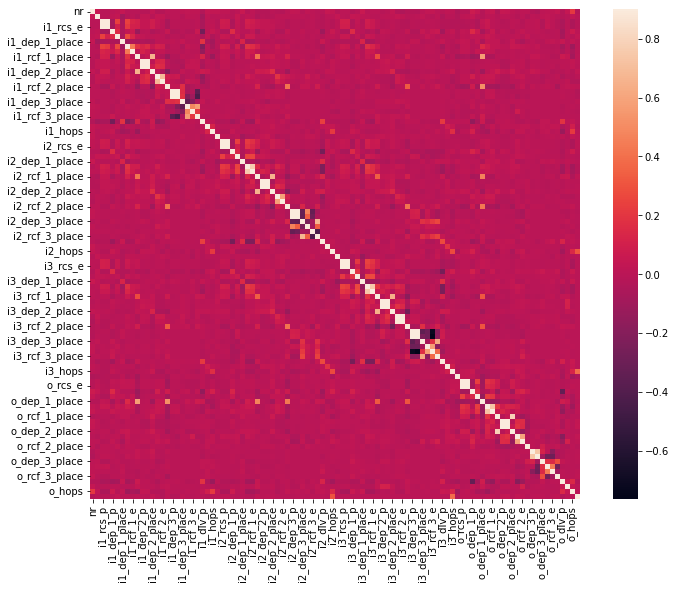

In [7]:
#Correlation map to see how features are correlated 
corrmat = df.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

All of the variables seem important, so I will continue with all of them except fo the nr, the irrelevant unique id. 

In [25]:
df.drop('nr', axis=1, inplace=True)
df.head()

,i1_legid,i1_rcs_p,i1_rcs_e,i1_dep_1_p,i1_dep_1_e,i1_dep_1_place,i1_rcf_1_p,i1_rcf_1_e,i1_rcf_1_place,i1_dep_2_p,...,o_dep_3_p,o_dep_3_e,o_dep_3_place,o_rcf_3_p,o_rcf_3_e,o_rcf_3_place,o_dlv_p,o_dlv_e,o_hops,legs
0,5182.000,199.000,218.000,210.000,215.000,609.000,935.000,736.000,256.000,891,...,785,846,546,1180,912,439,780.000,434.000,1.000,2
1,6523.000,844.000,584.000,90.000,297.000,700.000,1935.000,1415.000,431.000,891,...,785,846,546,1180,912,439,3870.000,445.000,1.000,2
2,5878.000,4380.000,4119.000,90.000,280.000,456.000,905.000,547.000,700.000,891,...,785,846,546,1180,912,439,550.000,1520.000,1.000,1
3,1275.000,759.000,169.000,240.000,777.000,173.000,340.000,577.000,349.000,1340,...,785,846,546,1180,912,439,3780.000,159.000,1.000,1
4,8117.000,1597.000,1485.000,150.000,241.000,411.000,585.000,612.000,128.000,340,...,785,846,546,1180,912,439,4140.000,4797.000,2.000,1


In [24]:
X = df.drop('legs',axis=1)
y=df['legs']

In [28]:
df.shape
X = np.array(df.iloc[:,:])[:3940,:]
y = np.array(y)[:3940]
# normalize
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

# split the train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2022)

## 2.2 Implementation of SVR

In [29]:
class SVR():
    '''
    This is a class for support vector regressor.
    
    The class contains the hyper-parameters such as $C$, $\epsilon$ and the kernel bandwidth $\sigma$. It also contains 
    the alpha vector, the tolerance for prediction error and the maximum number of iteration.
    
    It contains the functions for calculating the kernel matrix, fitting the model to estimate alpha, hat_alpha and b 
    with SMO algorithm, making predictions and other fundamental functions.
    
    Attributes:
        C (positive number)         - the hyperparameter for SVM algorithm
        sigma (positive number)     - the kernel bandwidth $\sigma$ of Gaussian kernel 
        toler (positive number)     - $\epsilon$, the threshold value of prediction error. If the prediction error of 
                                      a sample is larger than this value, the corresponding alphas[i] or hat_alpha[i]
                                      will be probably updated.
        maxIter (positive integer)  - the maximum number of iteration to search a pair of alpha's to update
        alphas (vector, num_samples) - the alpha vector in the dual problem 
        hat_alphas (vector, num_samples) - the hat_alpha vector in the dual problem 
        b (number)                  - the bias b
    '''
    
    def __init__(self, C = 1, sigma = 1, toler = 1, maxIter = 10):
        self.C = C
        self.sigma = sigma
        self.toler = toler
        self.maxIter = maxIter
        self.alphas = 0
        self.hat_alphas = 0
        self.b = 0
        
    def rbfkernel(self, X, Y):
        '''
        Calculate the kernel matrix whose (i,j)-th entry is $k(X[i,:], Y[j,:])$.
        '''
        m = X.shape[0]
        n = Y.shape[0]
        K = np.zeros(shape=(m, n))
        for i in range(m):
            for j in range(n):
                K[i, j] = np.sum((X[i,:] - Y[j,:])**2)
        K = np.exp(-K / (2 * self.sigma**2))
        return K

    def selectJrand(self, i, m):
        '''
        Randomly choose an index $j\neq i$ from 0 to m-1 and choose alpha[i] (or hat_alpha[i]) if hat_alpha[i] = 0 (or alpha[i]=0).
        '''
        j = i
        while (j == i):
            j = int(np.random.uniform(0, m))
        if self.alphas[j] == 0:
            choose_hat_j = 1
        else:
            choose_hat_j = 0
        return (j, choose_hat_j)


    def clipAlpha(self, aj, H, L):
        '''
        Clip the vale aj by the lower bound L and upper bound H
        '''
        if aj > H:
            aj = H
        if L > aj:
            aj = L
        return aj


    def fit(self, X_train, y_train):
        '''
        estimate the alphas vector, hat_alpha vector and bias in the SVM model
        
        Args: 
            X_train (matrix, num_train*num_features): features of training samples
            y_train (vector, num_train): output of training samples
            
        Returns:
            self.b (a number)                     : the bias
            self.alphas (vector, num_samples)     : the alpha vector 
            self.hat_alphas (vector, num_samples) : the hat_alpha vector 
        ''' 
        K_train = self.rbfkernel(X_train, X_train)
        self.X_train = X_train
        m = K_train.shape[0]
        self.alphas = np.zeros((m, ))
        self.hat_alphas = np.zeros((m, ))
        num_iter = 0
        while (num_iter < self.maxIter):
            alphaPairsChanged = 0
            # optimize for each data vector (with kernel trick)
            for i in range(m):  
                ### choose hat_alphas[i] or alphas[i] to update
                if self.hat_alphas[i] == 0:
                    choose_hat_i = 0
                else:
                    choose_hat_i = 1
                fXi = (self.hat_alphas - self.alphas) @ K_train[i, :] + self.b
                Ei = fXi - y_train[i]
                ### if statement checks if an example violates KKT conditions
                if (abs(Ei) < self.toler) or (self.alphas[i] == self.C) or (self.hat_alphas[i] == self.C):
                    continue
                else:
                    j, choose_hat_j = self.selectJrand(i, m)
                    fXj = (self.hat_alphas-self.alphas) @ K_train[j, :] + self.b
                    Ej = fXj - y_train[j]
                    alphaJold = self.alphas[j]
                    alphaIold = self.alphas[i]
                    hat_alphaJold = self.hat_alphas[j]
                    hat_alphaIold = self.hat_alphas[i]
                    if (choose_hat_i == 0) and (choose_hat_j == 1):
                        L = max(0, self.alphas[i] - self.hat_alphas[j])
                        H = min(self.C, self.C + self.alphas[i] - self.hat_alphas[j])
                    elif (choose_hat_i == 1) and (choose_hat_j == 0):
                        L = max(0, self.hat_alphas[i] - self.alphas[j])
                        H = min(self.C, self.C + self.hat_alphas[i] - self.alphas[j])
                    elif (choose_hat_i == 0) and (choose_hat_j == 0):
                        L = max(0, self.alphas[i] + self.alphas[j] - self.C)
                        H = min(self.C, self.alphas[i] + self.alphas[j])
                    else:
                        L = max(0, self.hat_alphas[i] + self.hat_alphas[j] - self.C)
                        H = min(self.C, self.hat_alphas[i] + self.hat_alphas[j])
                    if L == H:
                        continue
                    eta = 2.0 * K_train[j, i] - K_train[j, j] - K_train[i, i]
                    if eta >= 0:
                        continue
                    ### Update i 
                    if (choose_hat_i == 0) and (choose_hat_j == 1):
                        self.alphas[i] += (2 * self.toler - Ei + Ej) / eta
                    elif (choose_hat_i == 1) and (choose_hat_j == 0):
                        self.hat_alphas[i] += (2 * self.toler + Ei - Ej) / eta
                    elif (choose_hat_i == 0) and (choose_hat_j == 0):
                        self.alphas[i] += (-Ei + Ej) / eta
                    else:
                        self.hat_alphas[i] += (Ei - Ej) / eta
                    if choose_hat_i == 0:
                        self.alphas[i] = self.clipAlpha(self.alphas[i], H, L)
                    else:
                        self.hat_alphas[i] = self.clipAlpha(self.hat_alphas[i], H, L)
                    ### Whether the change amount is large enough or not
                    if choose_hat_i == 0:
                        if (abs(self.alphas[i] - alphaIold) < 0.00001):
                            continue
                    else:
                        if (abs(self.hat_alphas[i] - hat_alphaIold) < 0.00001):
                            continue
                    # update j by the same amount as i
                    if (choose_hat_i == 0) and (choose_hat_j == 1):
                        self.hat_alphas[j] += self.alphas[i] - alphaIold
                    elif (choose_hat_i == 1) and (choose_hat_j == 0):
                        self.alphas[j] += self.hat_alphas[i] - hat_alphaIold
                    elif (choose_hat_i == 0) and (choose_hat_j == 0):
                        self.alphas[j] += alphaIold - self.alphas[i]
                    else:
                        self.hat_alphas[j] += hat_alphaIold - self.hat_alphas[i]
                    # update b
                    b1 = self.b - Ej - (self.hat_alphas[j] - hat_alphaJold - (self.alphas[j] - alphaJold))    \
                        * K_train[j, j] - (self.hat_alphas[i] - hat_alphaIold - (self.alphas[i] - alphaIold)) * K_train[i, j]
                    b2 = self.b - Ei - (self.hat_alphas[j] - hat_alphaJold - (self.alphas[j] - alphaJold))   \
                        * K_train[j, i] - (self.hat_alphas[i] - hat_alphaIold - (self.alphas[i] - alphaIold)) * K_train[i, i]
                    if ((0 < self.alphas[j]) and (self.C > self.alphas[j])) or ((0 < self.hat_alphas[j]) and (self.C > self.hat_alphas[j])): 
                        self.b = b1
                    elif ((0 < self.alphas[i]) and (self.C > self.alphas[i])) or ((0 < self.hat_alphas[i]) and (self.C > self.hat_alphas[i])): 
                        self.b = b2
                    else: self.b = (b1 + b2) / 2.0
                    alphaPairsChanged += 1
            if (alphaPairsChanged == 0): 
                num_iter += 1
            else: 
                num_iter = 0
        return self.b, self.alphas, self.hat_alphas

    def predict(self, X_test):
        '''
        predict the label of test samples
        Args:
            X_test(matrix, num_test*num_features): features of test samples
        Returns:
            y_hat(vector, num_test): the predicted ouput of test samples
        '''
        K_test = self.rbfkernel(self.X_train, X_test)
        m = K_test.shape[0]
        y_hat = K_test.T @ (self.hat_alphas - self.alphas) + self.b
        return y_hat

## 1.3 Run SVR on the dataset

In [30]:
from sklearn.metrics import mean_squared_error
model_SVR = SVR(C = 0.5, sigma = 5, toler = 5, maxIter = 30)
b, alphas, hat_alphas = model_SVR.fit(X_train, y_train)
y_test_hat = model_SVR.predict(X_test)
mse = mean_squared_error(y_test_hat, y_test)
print("The MSE of SVR is:", mse)

The MSE of SVR is: 4.768189509306261


# Regession Tree

In [31]:
### criterion function for regression tree
def sum_squared_distance_to_mean(X, y):
    '''
    function used to calculate the squared error.
    '''
    n = X.shape[0]
    return np.var(y) * n

class DecisionTreeRegressor(object):
    '''
    This class is for decision tree regression

    Attributes:
        - criterion: a function used as the criterion of decision tree regression
        - tolS: a tolerance on the error reduction. we will stop the splitting if
            low error reduction.
        - tree: a nested dictionary representing the decision tree structure.
    '''
    def __init__(self, criterion, tolS=0.1):
        # Initialization
        self.criterion = criterion
        self.tolS = tolS

    def fit(self, X, y):
        '''
        function used to fit the decision tree regressor

        Args:
            X - features of training samples, a pandas dataframe with shape (n, d), where
                X.columns is the column name of X, and we can use X['feat'] to index all
                values of the feature named `feat`.
            y - target values (continuous, scaled) of training samples, a pandas series with shape (n,)
        '''
        self.tree = self.create_tree(X, y)

    def predict(self, X):
        '''
        function used to fit the decision tree regressor

        Args:
            X - features of test samples, a pandas dataframe with shape (n, d)

        Returns:
            y - predictions of test samples, a pandas series with shape (n,)
        '''
        n = X.shape[0]
        y = []
        for i in range(n):
            y.append(self.predict_each(X.iloc[i], self.tree))
        y = pd.Series(y)
        y.index = X.index
        return y

    @staticmethod
    def choose_best_split(X, y, criterion, tolS=1):
        '''
        function used to choose the best split feature and split point

        Args:
            X - features of test samples, a pandas dataframe with shape (n, d)
            y - target values of training samples, a pandas series with shape (n,)
            criterion - function used to measure the quality of a split
            tolS - a tolerance on the error reduction.

        Returns:
            best_feat: the feature used to split on for this node
            best_split: the value of the feature used to split for this node
        '''
        # used to calculate the error reduction
        origin_score = criterion(X, y)
        # initialize
        best_feat, best_split = None, None
        best_score = np.inf
        # search for each feature
        for feat in X.columns:
            # if all values of this feature are equal, do not split this feature
            X_feat_value = set(X[feat])
            if len(X_feat_value) == 1:
                continue
            # otherwise, search for each possible split point of this feature
            for split in X_feat_value:
                # divide the dataset into two parts according to the split
                idx1 = X[feat] < split
                idx2 = X[feat] >= split
                # calculate score to evaluate the quality of a split
                score1 = criterion(X.loc[idx1], y.loc[idx1])
                score2 = criterion(X.loc[idx2], y.loc[idx2])
                score = score1 + score2
                if score < best_score:
                    # choose the split with the largest (variance) reduction
                    best_feat = feat
                    best_split = split
                    best_score = score
        if origin_score - best_score < tolS:
            # Do not split if the (variance) reduction is low
            return None, None
        else:
            # return the feature and the value used for the split
            return best_feat, best_split

    def create_tree(self, X, y):
        '''
        build the decision tree regressor in a recursive manner.
        use a dictionary to represent tree node:
            if the tree node is an internal node, the dictionary will have the following five items:
                - tree["is_leaf"] stores whether the tree node is a leaf node or not.
                - tree["split_feat"] stores the feature used to split on for this node
                - tree["split_point"] stores the value of the feature used to split
                - tree["left"] is a (nested) dictionary used to store the left subtree of this node.
                - tree["right"] is a (nested) dictionary used to store the right subtree of this node.
            if the tree node is a leaf node, the dictionary will have the following two items:
                - tree["is_leaf"] stores whether the tree node is a leaf node or not.
                - tree["value"] stores the prediction at the leaf node
        returns a nested dictionary used to store the tree structure.
        '''
        Tree = {}
        # create a leaf node if all values are equal
        y_values, y_counts = np.unique(y, return_counts=True)
        if len(y_counts) == 1:
            Tree["is_leaf"] = True
            Tree["value"] = y_values[0]
            return Tree
        # create a leaf node if feature set is empty (a low error reduction)
        feat, split = self.choose_best_split(X, y, self.criterion, self.tolS)
        if feat is None:
            Tree["is_leaf"] = True
            Tree["value"] = y.mean()
            return Tree
        # otherwise, create an internal node
        Tree["is_leaf"] = False
        Tree["split_feat"] = feat
        Tree["split_point"] = split
        # divide the dataset (X, y) into two parts according to tree split
        # build the left subtree
        idx = X[feat] < split
        Tree["left"] = self.create_tree(X.loc[idx], y.loc[idx])
        # build the right subtree
        idx = X[feat] >= split
        Tree["right"] = self.create_tree(X.loc[idx], y.loc[idx])
        return Tree

    @staticmethod
    def predict_each(x, tree):
        '''
        for each sample, get the prediction of decision tree regressor in a recursive manner.

        Args:
            x - features of a sample, a pandas Series with shape (d,)
            tree - a nested dictionary representing the decision tree structure.

        Returns:
            the prediction of the sample `x`
        '''
        if tree["is_leaf"] is True:
            # if the `tree` is a leaf node, get the prediction at the leaf node
            return tree["value"]
        else:
            # the 'tree' is a nested dictionary with the following four items:
            #     `split_feat`, `split_point`, `left`, 'right`.
            # get the feature used to split on for this tree
            feat = tree["split_feat"]
            # get the value of the feature used to split
            split = tree["split_point"]
            # get the value of the feature for the sample `x`
            value = x[feat]
            if value < split:
                # search for the left subtree
                return DecisionTreeRegressor.predict_each(x, tree["left"])
            else:
                # search for the right subtree
                return DecisionTreeRegressor.predict_each(x, tree["right"])


In [32]:
def run():
    # dataset preparation
    X, y = main()[0], main()[2]
    # initialize the decision tree regressor
    model = DecisionTreeRegressor(criterion=sum_squared_distance_to_mean, tolS=0.1)
    # fit the regression tree
    model.fit(X, y)
    # get the prediction of samples
    y_hat = model.predict(main()[1])
    # calculate the mean squared error of samples
    print("The MSE of Random Regression Tree is:", ((y - y_hat)**2).mean())

In [33]:
run()

The MSE of Random Regression Tree is: nan


# Using PCA for overfitting

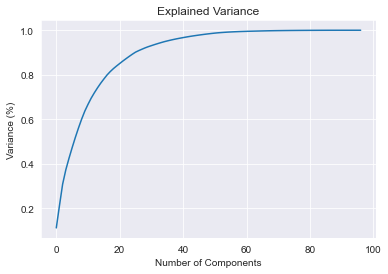

In [34]:
from sklearn.decomposition import PCA
import numpy as np
pca = PCA()
principalComponents = pca.fit_transform(X)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

In [35]:
pca = PCA(n_components=60)
pc = pca.fit_transform(X)

pc = pd.DataFrame(pc,index=X.index)
pc

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [ ]:
X_train2,X_test2,y_train2,y_test2 = train_test_split(pc,y,test_size = 0.3)

In [ ]:
from sklearn.metrics import mean_squared_error
model_SVR = SVR(C = 0.5, sigma = 5, toler = 5, maxIter = 30)
b, alphas, hat_alphas = model_SVR.fit(X_train2, y_train2)
y_test_hat = model_SVR.predict(X_test2)
mse = mean_squared_error(y_test_hat, y_test2)
print("The MSE of SVR is:", mse)